# Import dependencies

In [2]:

import numpy as np
import scipy
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solveStateEquation import getSourceTerm, solveStateEquation, buildControlFunction
from src.solveAdjointEquation import solveAdjointEquation
from src.visualization import plot_array, printIterationInfo, timeDependentVariableToGif
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient, integrateVectorFunction, getIdxMax, calculateFirstDual, showNonStationarity
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists

# Set parameters

In [3]:
@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    alpha = 1e-7
    beta = 1e-7
    waveSpeed = 2
    randomFactor = 5
    maxIterations = 20
    pruneThreshold = 1e-11
    yd = []
    yd_adjoint = []
    yd_firstDual = None
    yd_secondDual = None
    standardInnerProducts = None
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
params = Parameters()

# Setup problem

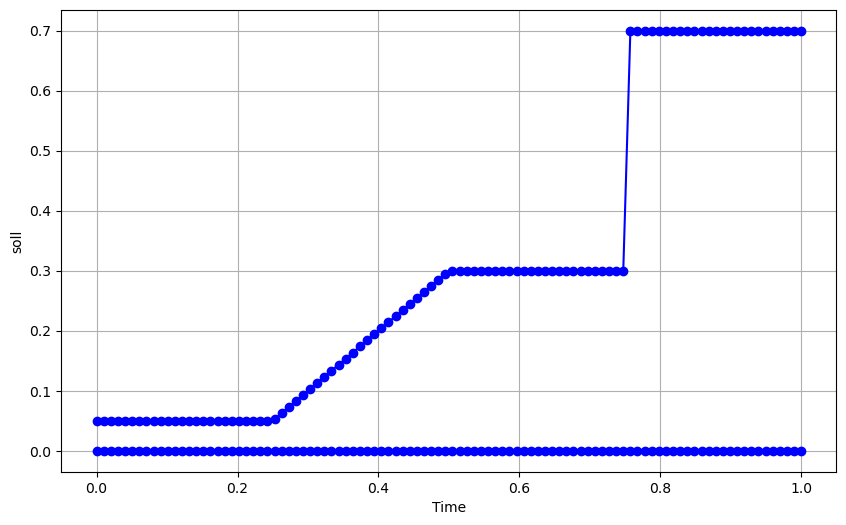

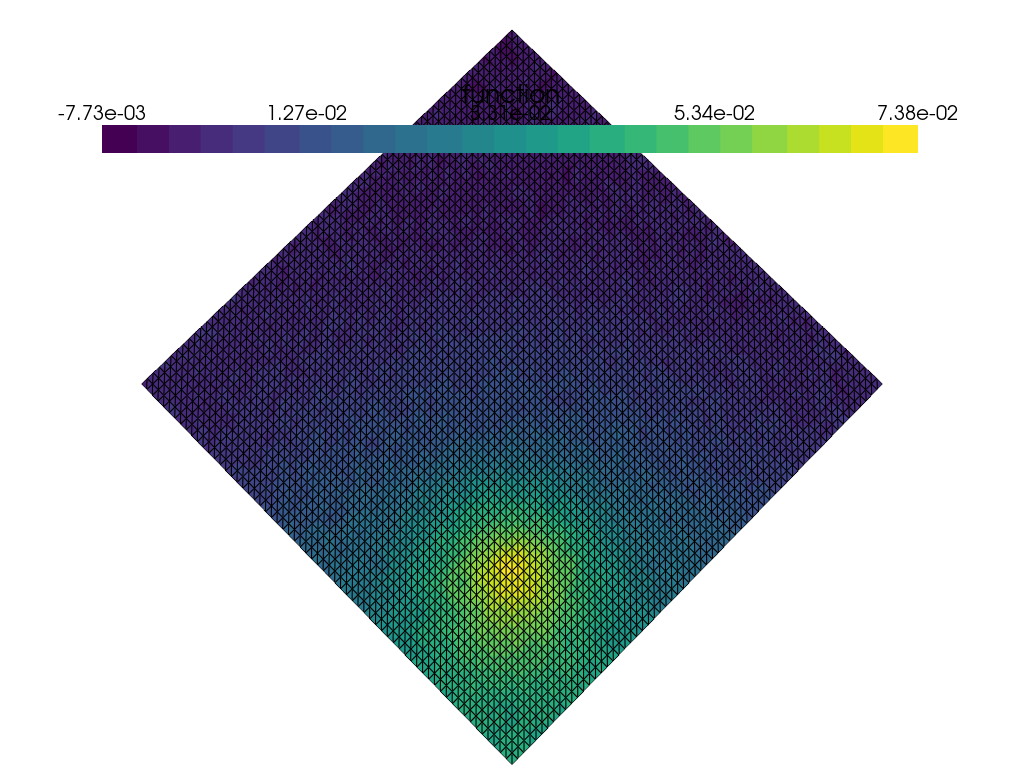

In [4]:
#s1 = lambda t : (0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35))) #/ params.alpha
#s2 = lambda t : (0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275))) #/ params.alpha
s1 = lambda t : (0.05 if t <= 0.25 else (t - 0.2 if t <= 0.5 else 0.3 if t <= 0.75 else 0.7)) #/ params.alpha
s2 = lambda t : 0#(0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275))) #/ params.alpha
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
control = buildControlFunction([g1, g2], [s1, s2], params)
K_u = solveStateEquation(control, params)
grid_size = K_u[0].x.array.shape
raw_matrices = [K_u_t.x.array for K_u_t in K_u]
norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
np.random.seed(42)
yd = [fem.Function(params.V) for _ in K_u]
for idx in range(len(yd)):
    yd[idx].x.array[:] = K_u[idx].x.array + np.random.normal(loc=0.0, scale=scale, size=grid_size)
params.yd = yd
params.yd_adjoint = solveAdjointEquation(params.yd, params)
s1_primitive = lambda t: 0. if t < 0.5 else t - 0.5
s2_primitive = lambda t: 0.
#primControl = buildControlFunction([g1, g2], [s1_primitive, s2_primitive], params)
#params.yd_firstDual = solveStateEquation(primControl, params)
firstDual = [fem.Function(params.V) for _ in K_u]
timePoints = np.linspace(0, params.T, num=len(yd))
for idx_x in range(firstDual[0].x.array.shape[0]):
    array = [func.x.array[idx_x] for func in yd]
    integrated_array = scipy.integrate.cumulative_simpson(array, x=timePoints, initial=0)
    for idx_t, func in enumerate(firstDual):
        func.x.array[idx_x] = integrated_array[idx_t]
secondDual = [fem.Function(params.V) for _ in K_u]
for idx_x in range(secondDual[0].x.array.shape[0]):
    array = [func.x.array[idx_x] for func in firstDual]
    integrated_array = scipy.integrate.cumulative_simpson(array, x=timePoints, initial=0)
    for idx_t, func in enumerate(secondDual):
        func.x.array[idx_x] = -integrated_array[idx_t]
params.yd_firstDual = solveAdjointEquation(firstDual, params)
params.yd_secondDual = solveAdjointEquation(secondDual, params)
#array_list = [func.x.array for func in yd]
#for idx in range(len(yd)):
#    dual[idx].x.array[:] = 

discretInterval = np.linspace(0, params.T, int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in discretInterval])
array[:, 1] = np.array([s2(t) for t in discretInterval])
#params.yd_firstDual = integrate.cumulative_simpson
plot_array(array, params.T, label='soll')
timeDependentVariableToGif(yd, 'output/observation.gif')

# Minimization algorithm

Objective upper bound:  0.020748634435369413
weights:  [] slope:  [ 0.61534241 -0.00357334] y_shift [-0.03761473  0.00321815]
Objective:  1.3749235648183094e-05
0 : Active set:
slope:  [ 0.61534241 -0.00357334] y_shift [-0.03761473  0.00321815]
0 : Hesse condition: 177.27430439667648
First conditions:  [ 1.71876506e-10  6.37667014e-11  1.19685392e-07 -9.97474501e-09]  (should be close to 0)
Second conditions:  []  (should be greater or equal than 0)


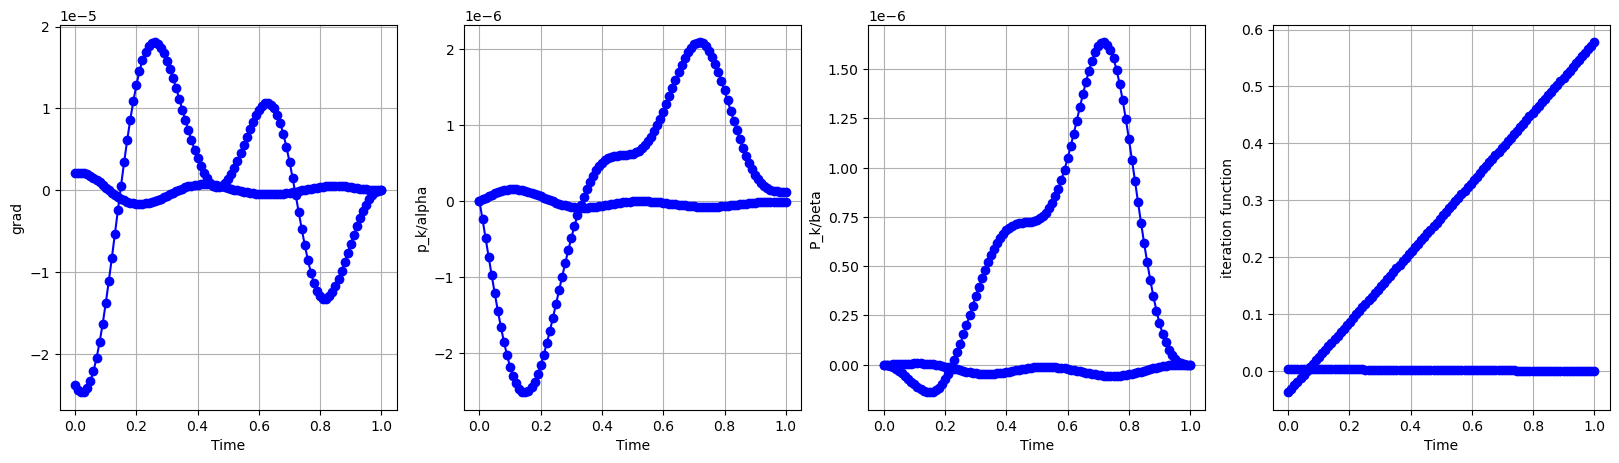

VALUES DUAL END FIRST:  [ 1.19685392e-07 -9.97474501e-09] SECOND:  [1.71876506e-10 6.37667014e-11]
|p_max|/alpha:  25.22069667518984 , |P_max|/beta:  163.75859744637037
x_S:  0.15 x_K:  0.72 
New point: sigma= [ 0.99941593 -0.03417295] x_0 = 0.72 , type = 1
weights:  [9.20338772e-08] slope:  [0.01667057 0.00667365] y_shift [0.03507396 0.01325921]
Objective:  6.0375790295736734e-05
1 : Active set:
	 0 sigma= [ 0.99941593 -0.03417295] ,	x_0 = 0.72 ,	type = 1 	weight: 9.203387722466962e-08 	id: 139842246517168
slope:  [0.01667057 0.00667365] y_shift [0.03507396 0.01325921]
1 : Hesse condition: 132927114437457.12
First conditions:  [-6.70119887e-05  2.76167287e-06 -2.05579484e-04 -4.63529655e-06]  (should be close to 0)
Second conditions:  [4.00059557]  (should be greater or equal than 0)


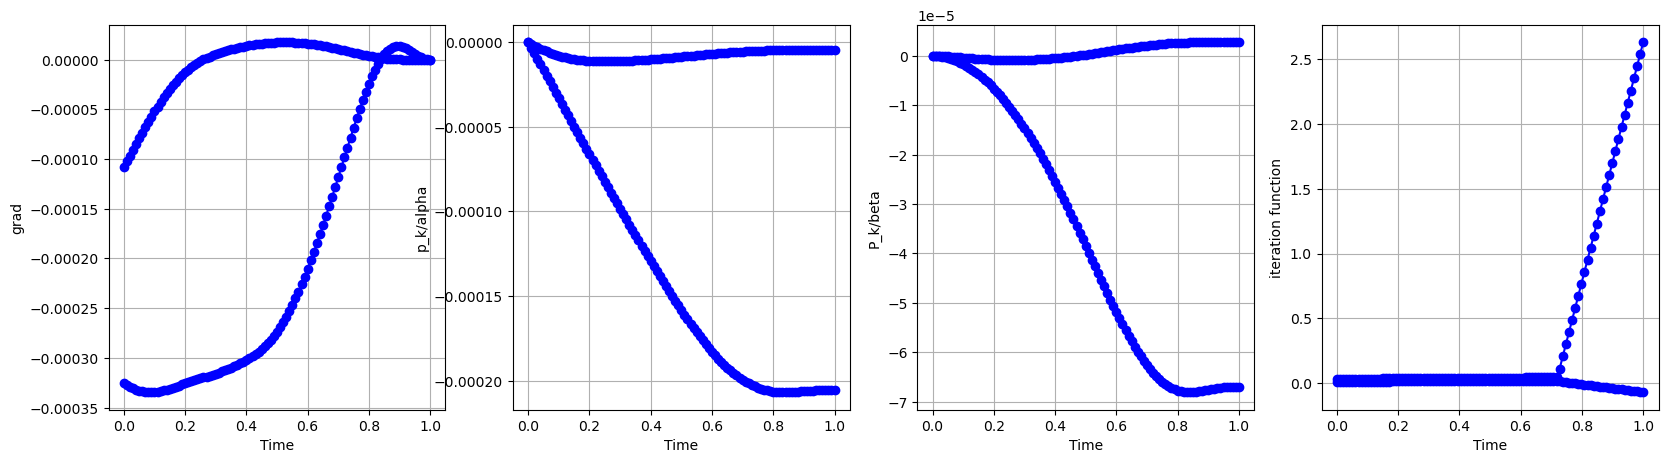

VALUES DUAL END FIRST:  [-2.05579484e-04 -4.63529655e-06] SECOND:  [-6.70119887e-05  2.76167287e-06]
|p_max|/alpha:  2068.407239041526 , |P_max|/beta:  6815.76929061076
x_S:  0.84 x_K:  0.84 
New point: sigma= [-0.99920564  0.03985081] x_0 = 0.84 , type = 1
weights:  [1.63508588e-07 3.72789299e-07] slope:  [0.0151354 0.0070128] y_shift [0.032564   0.01291186]
Objective:  5.649230896955349e-05
2 : Active set:
	 0 sigma= [ 0.99941593 -0.03417295] ,	x_0 = 0.72 ,	type = 1 	weight: 1.6350858793756539e-07 	id: 139842246517168
	 1 sigma= [-0.99920564  0.03985081] ,	x_0 = 0.84 ,	type = 1 	weight: 3.7278929927788937e-07 	id: 139842243076240
slope:  [0.0151354 0.0070128] y_shift [0.032564   0.01291186]
2 : Hesse condition: 150114315435190.3
First conditions:  [-6.11318579e-05  2.34177606e-06 -1.92194604e-04 -4.98932475e-06]  (should be close to 0)
Second conditions:  [2.32680316 1.07402807]  (should be greater or equal than 0)


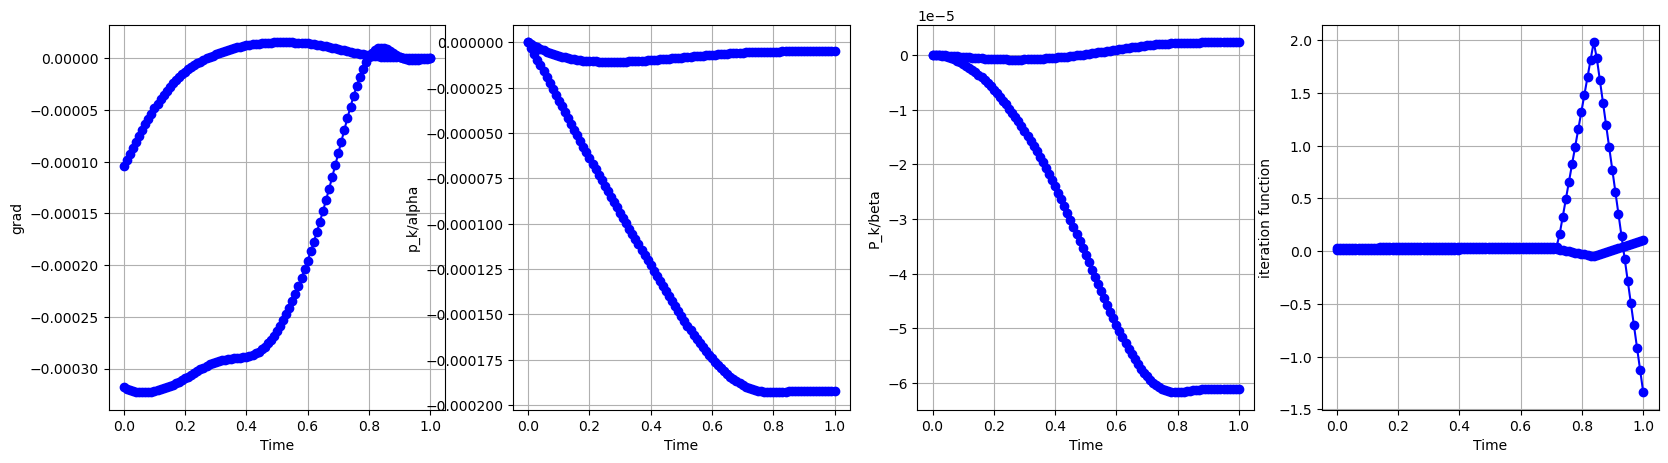

VALUES DUAL END FIRST:  [-1.92194604e-04 -4.98932475e-06] SECOND:  [-6.11318579e-05  2.34177606e-06]
|p_max|/alpha:  1928.8997463907126 , |P_max|/beta:  6169.081506128637
x_S:  0.8 x_K:  0.8 
New point: sigma= [-0.99937417  0.03537315] x_0 = 0.8 , type = 1
weights:  [2.31149942e-07 8.46254618e-10 3.60558281e-07] slope:  [0.014565  0.0072187] y_shift [0.03160745 0.01279389]
Objective:  5.4831254366949024e-05
3 : Active set:
	 0 sigma= [ 0.99941593 -0.03417295] ,	x_0 = 0.72 ,	type = 1 	weight: 2.3114994178771502e-07 	id: 139842246517168
	 1 sigma= [-0.99920564  0.03985081] ,	x_0 = 0.84 ,	type = 1 	weight: 8.462546176240168e-10 	id: 139842243076240
	 2 sigma= [-0.99937417  0.03537315] ,	x_0 = 0.8 ,	type = 1 	weight: 3.605582813530598e-07 	id: 139842232233056
slope:  [0.014565  0.0072187] y_shift [0.03160745 0.01279389]
3 : Hesse condition: 189186319108528.53
First conditions:  [-5.84761937e-05  2.13570992e-06 -1.85904662e-04 -5.07790360e-06]  (should be close to 0)
Second conditions:  [1.

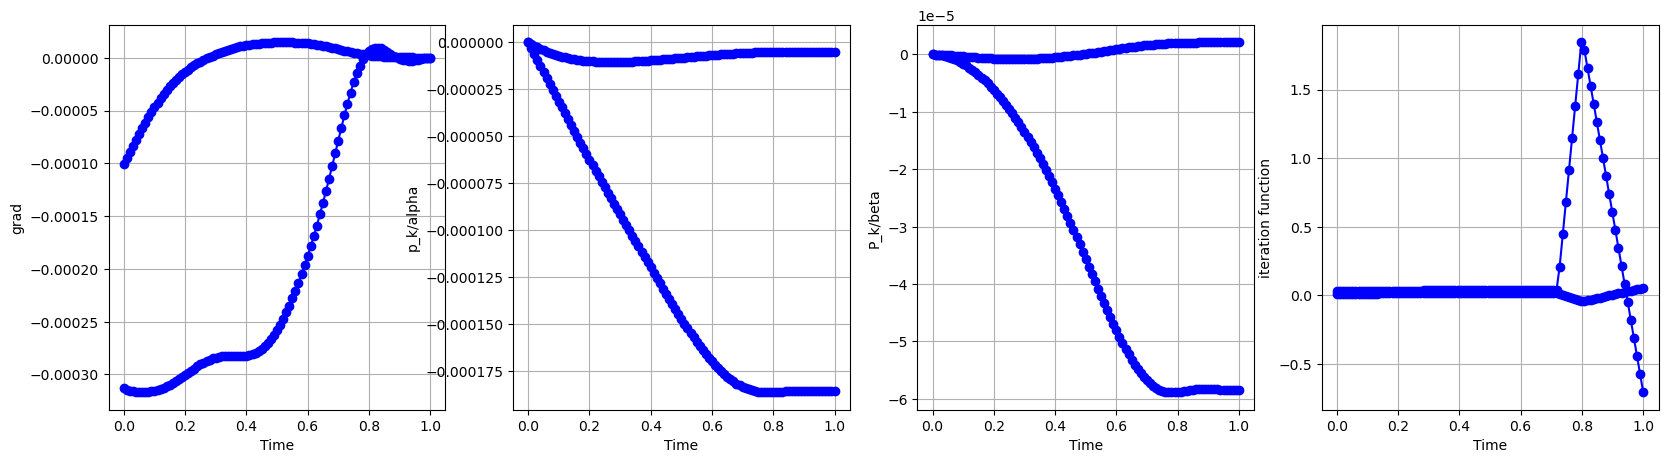

VALUES DUAL END FIRST:  [-1.85904662e-04 -5.07790360e-06] SECOND:  [-5.84761937e-05  2.13570992e-06]
|p_max|/alpha:  1864.7902757442628 , |P_max|/beta:  5890.63219455144
x_S:  0.78 x_K:  0.78 
New point: sigma= [-0.99944818  0.03321646] x_0 = 0.78 , type = 1
weights:  [2.54314369e-07 8.44343897e-10 1.38926626e-10 3.37120497e-07] slope:  [0.02463109 0.00135568] y_shift [0.05275207 0.01217915]
Objective:  3.801461201051932e-05
4 : Active set:
	 0 sigma= [ 0.99941593 -0.03417295] ,	x_0 = 0.72 ,	type = 1 	weight: 2.5431436924844506e-07 	id: 139842246517168
	 1 sigma= [-0.99920564  0.03985081] ,	x_0 = 0.84 ,	type = 1 	weight: 8.44343897055889e-10 	id: 139842243076240
	 2 sigma= [-0.99937417  0.03537315] ,	x_0 = 0.8 ,	type = 1 	weight: 1.389266259123732e-10 	id: 139842232233056
	 3 sigma= [-0.99944818  0.03321646] ,	x_0 = 0.78 ,	type = 1 	weight: 3.371204965528813e-07 	id: 139842057053936
slope:  [0.02463109 0.00135568] y_shift [0.05275207 0.01217915]
4 : Hesse condition: 253443244561274.8
F

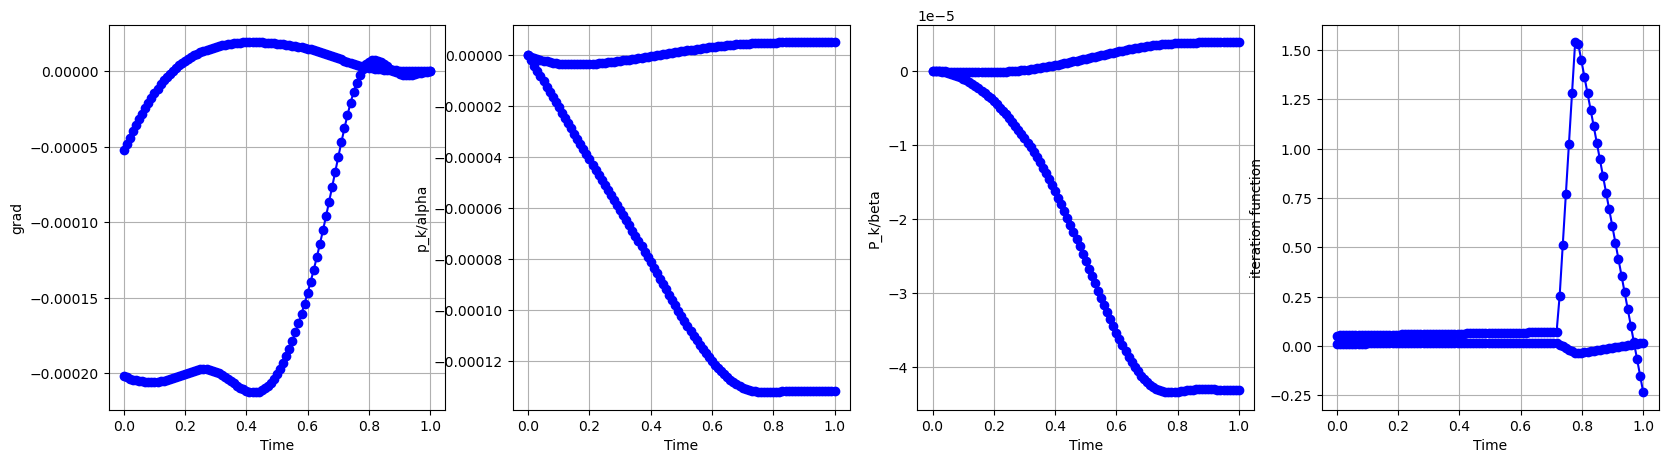

VALUES DUAL END FIRST:  [-1.31682049e-04  5.11807175e-06] SECOND:  [-4.30598333e-05  3.90512859e-06]
|p_max|/alpha:  1321.334562003047 , |P_max|/beta:  4349.634864972024
x_S:  0.78 x_K:  0.77 
New point: sigma= [-0.99637032  0.08512458] x_0 = 0.77 , type = 1
weights:  [2.72535037e-07 7.66699296e-10 1.17071299e-10 1.74261262e-07
 1.74528590e-07] slope:  [ 0.02452144 -0.00122387] y_shift [0.05260245 0.01149324]
Objective:  3.800006851778005e-05
5 : Active set:
	 0 sigma= [ 0.99941593 -0.03417295] ,	x_0 = 0.72 ,	type = 1 	weight: 2.725350368516409e-07 	id: 139842246517168
	 1 sigma= [-0.99920564  0.03985081] ,	x_0 = 0.84 ,	type = 1 	weight: 7.666992955469467e-10 	id: 139842243076240
	 2 sigma= [-0.99937417  0.03537315] ,	x_0 = 0.8 ,	type = 1 	weight: 1.1707129944637095e-10 	id: 139842232233056
	 3 sigma= [-0.99944818  0.03321646] ,	x_0 = 0.78 ,	type = 1 	weight: 1.74261262164917e-07 	id: 139842057053936
	 4 sigma= [-0.99637032  0.08512458] ,	x_0 = 0.77 ,	type = 1 	weight: 1.74528590191691

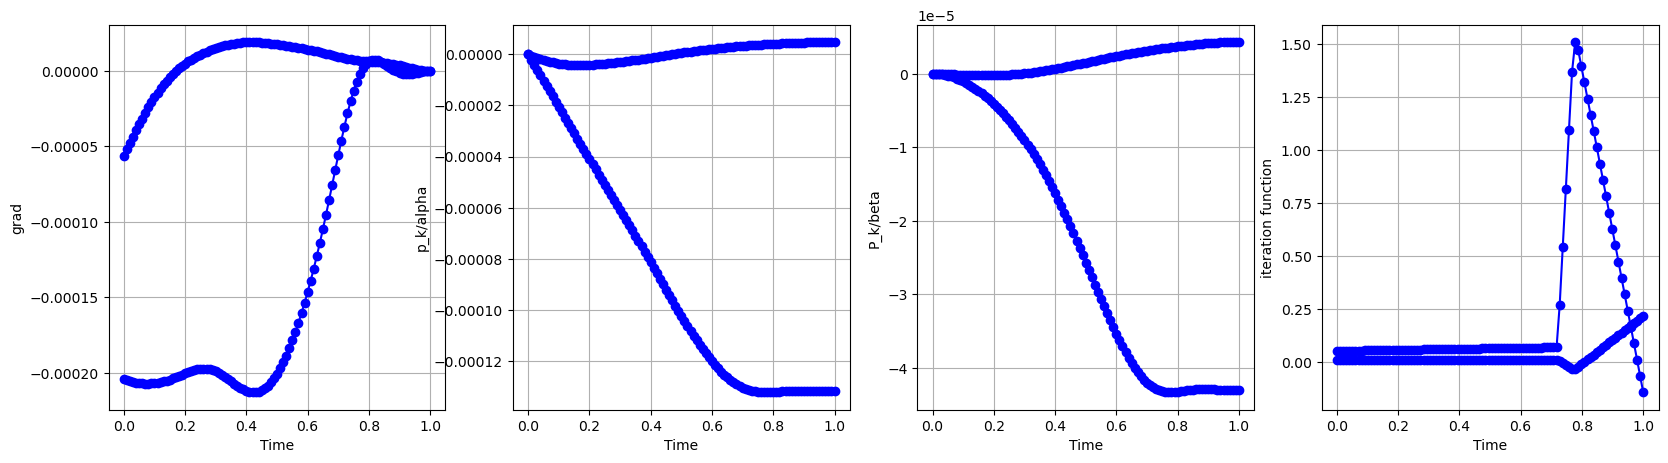

VALUES DUAL END FIRST:  [-1.31879200e-04  4.75077358e-06] SECOND:  [-4.30316898e-05  4.28373280e-06]
|p_max|/alpha:  1323.0439993735538 , |P_max|/beta:  4344.7920489273665
x_S:  0.78 x_K:  0.79 
New point: sigma= [-0.99643134  0.08440723] x_0 = 0.79 , type = 1
weights:  [2.72171659e-07 7.71985916e-10 1.18679994e-10 1.77449477e-07
 1.71029941e-07 9.52501182e-11] slope:  [ 0.02452446 -0.0012261 ] y_shift [0.05260946 0.01151875]
Objective:  3.7995578746489085e-05
6 : Active set:
	 0 sigma= [ 0.99941593 -0.03417295] ,	x_0 = 0.72 ,	type = 1 	weight: 2.721716591450196e-07 	id: 139842246517168
	 1 sigma= [-0.99920564  0.03985081] ,	x_0 = 0.84 ,	type = 1 	weight: 7.719859160645365e-10 	id: 139842243076240
	 2 sigma= [-0.99937417  0.03537315] ,	x_0 = 0.8 ,	type = 1 	weight: 1.186799939043755e-10 	id: 139842232233056
	 3 sigma= [-0.99944818  0.03321646] ,	x_0 = 0.78 ,	type = 1 	weight: 1.7744947672620187e-07 	id: 139842057053936
	 4 sigma= [-0.99637032  0.08512458] ,	x_0 = 0.77 ,	type = 1 	weigh

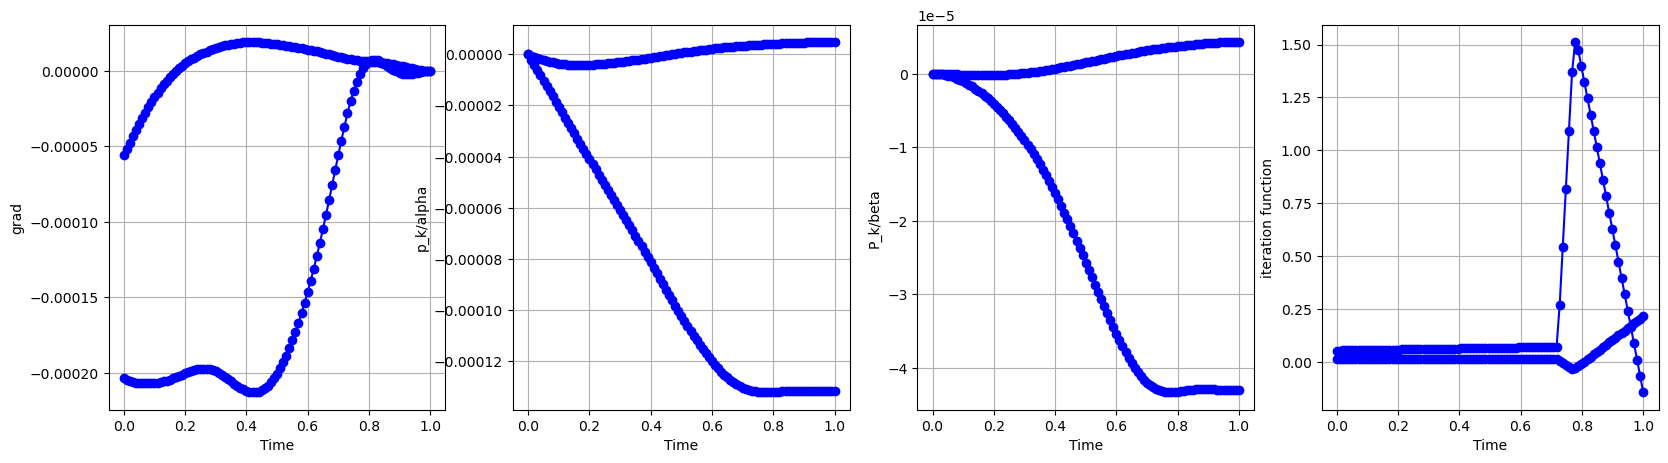

VALUES DUAL END FIRST:  [-1.31864109e-04  4.75042938e-06] SECOND:  [-4.30288088e-05  4.27243437e-06]
|p_max|/alpha:  1322.8952444042895 , |P_max|/beta:  4342.194654897769


In [8]:
active_set = []
hesse = HesseMatrix(active_set, params)
weights = np.ones(len(active_set))
slope = np.ones(params.d)
y_shift = np.ones(params.d)
constraintViolation = np.empty(params.maxIterations)
constraintViolation[:] = np.nan
print('Objective upper bound: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
weights, slope, y_shift = computeOSQPStep(weights, slope, y_shift, active_set, hesse, params)
print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
for k in range(params.maxIterations):
    printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
    u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
    discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse.standard_adjoints, params)
    showNonStationarity(discreteDf, active_set, params)
    #p_k = calculateFirstDual(active_set, weights, slope, y_shift, hesse.standard_firstDual, params)
    #P_k = -integrateVectorFunction(p_k, params)
    p_k = integrateVectorFunction(discreteDf, params)
    timePoints = np.linspace(0, params.T, num=len(discreteDf[:,0]))
    P_k = integrateVectorFunction(discreteDf * timePoints[:, np.newaxis], params)
    
    fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
    plot_array(discreteDf, params.T, label='grad', ax=ax1)
    plot_array(p_k, params.T, label='p_k/alpha', ax=ax2)
    plot_array(P_k, params.T, label='P_k/beta', ax=ax3)
    plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function', ax=ax4)
    mpl.pyplot.show()
    print('VALUES DUAL END FIRST: ', p_k[-1], 'SECOND: ', P_k[-1])
    
    '''fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
    plot_array(discreteDf, params.T, label='grad', ax=ax1)
    plot_array(p_k_old / params.alpha, params.T, label='p_k/alpha (old)', ax=ax2)
    plot_array(P_k_old / params.beta, params.T, label='P_k/beta (old)', ax=ax3)
    plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function', ax=ax4)
    mpl.pyplot.show()'''
    
    idx_S = getIdxMax(p_k, active_set, type=0)
    idx_K = getIdxMax(P_k, active_set, type=1)
    norm_p_max = np.linalg.norm(p_k[idx_S])
    norm_P_max = np.linalg.norm(P_k[idx_K])
    
    print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
    constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
    if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
        break
    if norm_p_max / params.alpha >= norm_P_max / params.beta:
        active_set.append(ExtremalPoint(p_k[idx_S] / norm_p_max, idx_S * params.dt, type=0, params=params))
    else:
        active_set.append(ExtremalPoint(P_k[idx_K] / norm_P_max, idx_K * params.dt, type=1, params=params))

    print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)
    hesse.extendMatrix(active_set[-1])
    weights, slope, y_shift = computeOSQPStep(np.concatenate((weights, np.array([0.]))), slope, y_shift, active_set, hesse, params)
    print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
    active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
    hesse.pruneMatrix(active_set, weights)
    print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))

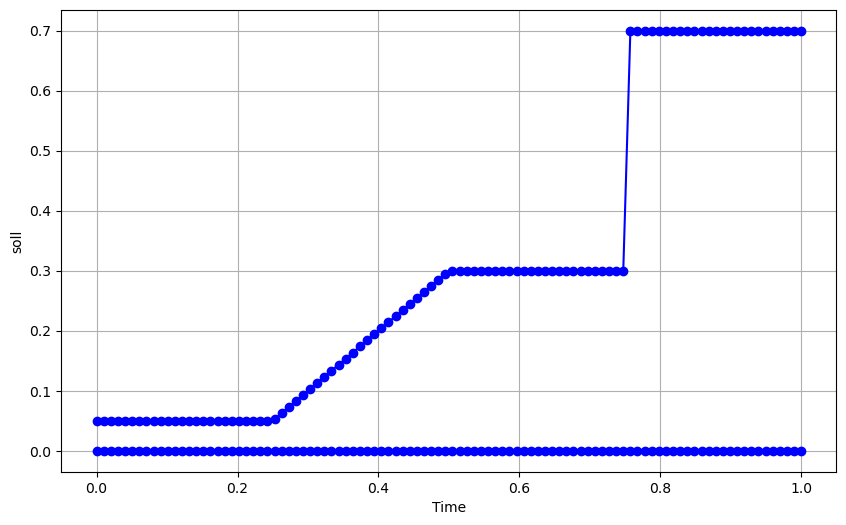

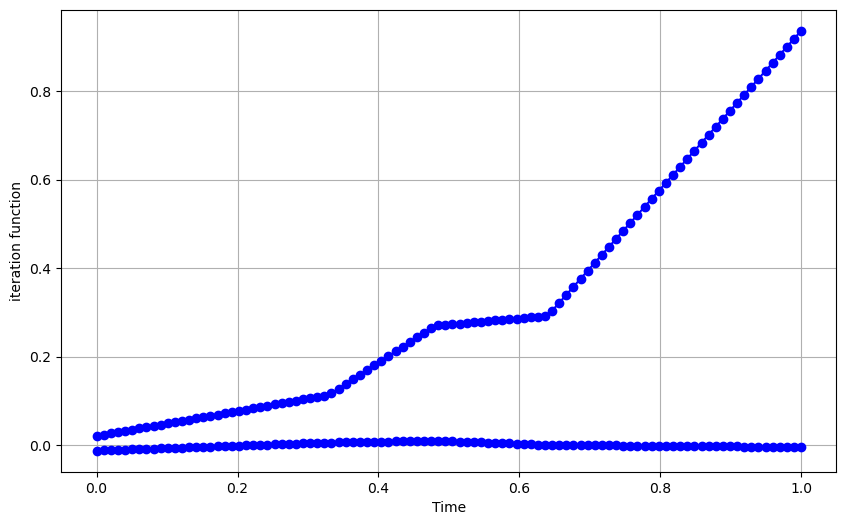

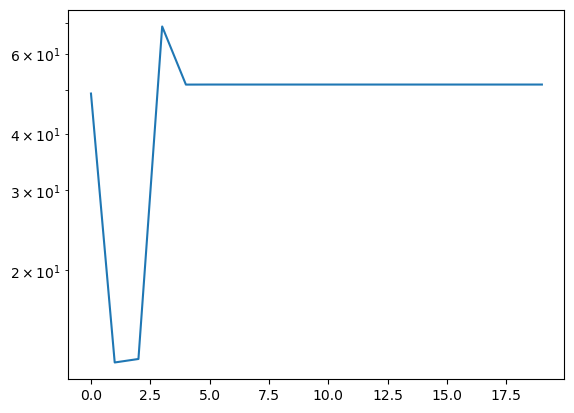

In [6]:
plot_array(array, params.T, label='soll')
plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function')
#plot_array(constraintViolation, params.maxIterations, label='violation')

mpl.pyplot.yscale('log')
mpl.pyplot.plot(constraintViolation)